In [166]:
import pandas as pd
import numpy as np

from hmmlearn import hmm
from pandas_datareader.data import DataReader

from ta.momentum import rsi
from ta.trend import ema_indicator
from ta.volatility import  BollingerBands,average_true_range

import yfinance as yf
yf.pdr_override()

import matplotlib.pyplot as plt

In [167]:
# Data Extraction
start_date = '2021-01-01'

symbol = 'BTC-USD'
data = yf.download(symbol,start_date) 

[*********************100%%**********************]  1 of 1 completed


In [168]:
# Implement the Indicators

# Initialize Bollinger Bands Indicator
indicator_bb = BollingerBands(close=data["Close"], window=14, window_dev=1.5)

# Add Bollinger Bands features
data['bb_middle'] = indicator_bb.bollinger_mavg()
data['bb_upper'] = indicator_bb.bollinger_hband()
data['bb_lower'] = indicator_bb.bollinger_lband()

# Initialize RSI Indicator
data['RSI'] = rsi(data["Close"], window=14)

data['returns'] = data['Adj Close']/data['Adj Close'].shift(1) - 1  
data['range'] = data['High']/data['Low'] -1

data.dropna(inplace=True)

save_df=data.iloc[800:]

save_df.head()

,Open,High,Low,Close,Adj Close,Volume,bb_middle,bb_upper,bb_lower,RSI,returns,range
Date,,,,,,,,,,,,
2020-03-24,6436.642578,6789.022949,6411.066406,6734.803711,6734.803711,48221910672,5862.397531,7041.460496,4683.334566,47.200416,0.049637,0.058954
2020-03-25,6738.716797,6892.511230,6536.926270,6681.062988,6681.062988,44590107888,5774.514160,6672.155478,4876.872842,46.654438,-0.007980,0.054396
2020-03-26,6675.170898,6735.463867,6590.962891,6716.440430,6716.440430,35319797642,5899.203613,6798.953796,4999.453430,47.088336,0.005295,0.021924
2020-03-27,6719.389160,6793.836426,6466.701660,6469.798340,6469.798340,34585598367,5963.924421,6877.358080,5050.490762,44.378234,-0.036722,0.050588
2020-03-28,6467.253906,6467.500977,6117.837891,6242.193848,6242.193848,34885225901,6038.340681,6898.948576,5177.732786,41.977274,-0.035180,0.057155


In [169]:
# Structure Data for HMM
X_train = data[['RSI','bb_middle','bb_upper','bb_lower','returns','range']].values
X_test = data[['RSI','bb_middle','bb_upper','bb_lower','returns','range']].iloc[800:].values


print(np.isnan(X_train).any()) 
print(np.isinf(X_train).any()) 

False
False


In [170]:
# Train Gaussian HMM
model = hmm.GaussianHMM(n_components=6, covariance_type="diag", n_iter=1000)
model.fit(X_train)

GaussianHMM(n_components=6, n_iter=1000)

In [171]:
# Check Results
hidden_states = model.predict(X_train)
hidden_states[:30]

array([5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [172]:
# Structure Prices for plotting

prices = data['Adj Close'].values.astype(float)
print('Correct number of rows ', len(prices)==len(hidden_states))

i=0
labels_0 = []
labels_1 = []
labels_2 = []
labels_3 = []
labels_4 = []
labels_5 = []

for state in hidden_states:
    if state == 0:
        labels_0.append(prices[i])
        labels_1.append(np.nan)
        labels_2.append(np.nan)
        labels_3.append(np.nan)
        labels_4.append(np.nan)
        labels_5.append(np.nan)
        
    elif state == 1:
        labels_0.append(np.nan)
        labels_1.append(prices[i])
        labels_2.append(np.nan)
        labels_3.append(np.nan)
        labels_4.append(np.nan)
        labels_5.append(np.nan)

    elif state == 2:
        labels_0.append(np.nan)
        labels_1.append(np.nan)
        labels_2.append(prices[i])
        labels_3.append(np.nan)
        labels_4.append(np.nan)
        labels_5.append(np.nan)
    elif state == 3:
        labels_0.append(np.nan)
        labels_1.append(np.nan)
        labels_2.append(np.nan)
        labels_3.append(prices[i])
        labels_4.append(np.nan)
        labels_5.append(np.nan)
    elif state == 4:
        labels_0.append(np.nan)
        labels_1.append(np.nan)
        labels_2.append(np.nan)
        labels_3.append(np.nan)
        labels_4.append(prices[i])
        labels_5.append(np.nan)
        
    else:
        labels_0.append(np.nan)
        labels_1.append(np.nan)
        labels_2.append(np.nan)
        labels_3.append(np.nan)
        labels_4.append(np.nan)
        labels_5.append(prices[i])
        

    i+=1



Correct number of rows  True


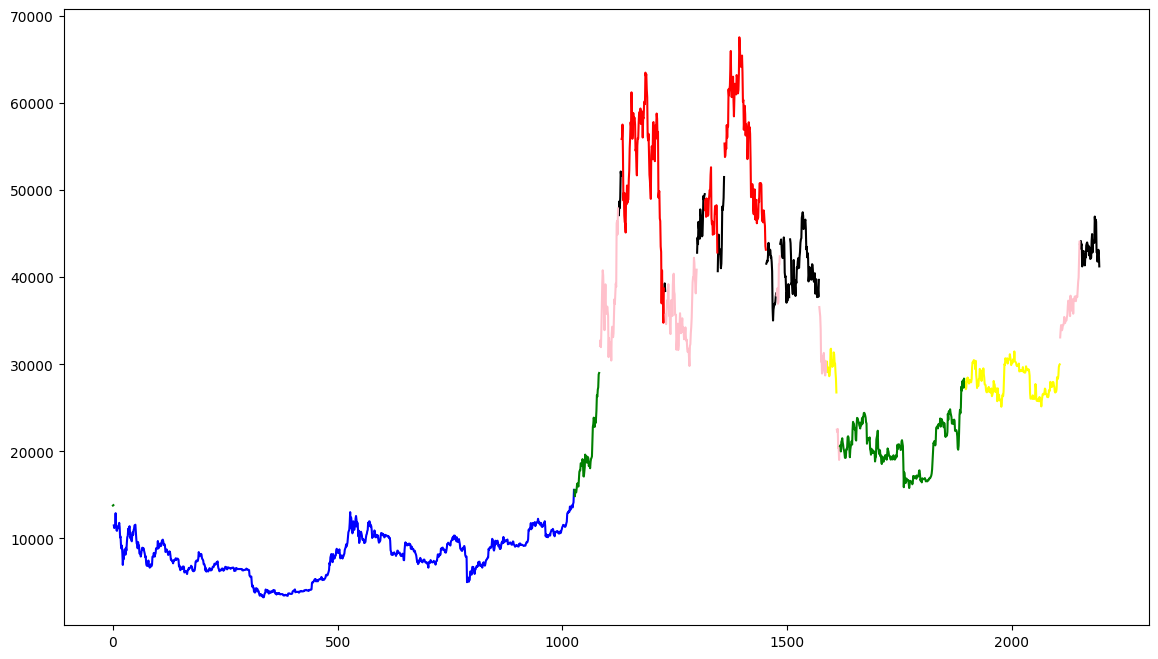

In [173]:
# Plot Results

fig = plt.figure(figsize=(14,8))
plt.plot(labels_0, color='yellow')
plt.plot(labels_1, color='blue')
plt.plot(labels_2, color='black')
plt.plot(labels_3, color='red')
plt.plot(labels_4, color='pink')
plt.plot(labels_5, color='green')

plt.show()